In [ ]:
#Практична робота 4 Винник Михайло ФБ-52мп

## Завдання 1: Генерація текстів

In [1]:
!pip install tensorflow torch torchvision transformers diffusers accelerate -q
!pip install sentencepiece -q
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.optimizers import RMSprop
import random
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from transformers import pipeline
from diffusers import StableDiffusionPipeline

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [2]:
file_path = 'Franko_-Zibrannya-tvoriv-u-p-yatdesyati-tomah-literaturno-kritichni-praci-1900-1902-tom-33-.382254.txt'
if os.path.exists(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()

text = text.lower()

print(f"Файл успішно зчитано. Довжина тексту: {len(text)} символів.")
print(f"Перші 100 символів тексту:\n{text[:100]}...")

chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

maxlen = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print(f"Кількість унікальних символів: {len(chars)}")
print(f"Кількість тренувальних послідовностей: {len(sentences)}")

Файл успішно зчитано. Довжина тексту: 1055030 символів.
Перші 100 символів тексту:
﻿   іван франко
   академія наук української рср
   
   видавництво «наукова думка» київ—1982
     м...
Кількість унікальних символів: 117
Кількість тренувальних послідовностей: 351664


In [3]:
# Архітектура моделі
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_lstm.add(Dense(len(chars), activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.01))

# Навчання
history = model_lstm.fit(x, y, batch_size=128, epochs=20)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 2.6175
Epoch 2/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 2.0108
Epoch 3/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 1.8869
Epoch 4/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 1.8279
Epoch 5/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 1.7875
Epoch 6/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 1.7642
Epoch 7/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 1.7432
Epoch 8/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 1.7308
Epoch 9/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 1.7133
Epoch 10/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 1.7065
Epoch 11/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 1.6924
Epoch 12/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 1.6915
Epoch 13/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 1.6795
Epoch 14/20
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 1.6727
Epoch 15/20
274

In [4]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(length=200, temperature=0.5):
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index : start_index + maxlen]
    generated += sentence
    print(f'--- Початок генерації з: "{sentence}"')

    for i in range(length):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model_lstm.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char
        generated += next_char

    return generated

print(generate_text())

--- Початок генерації з: " найбільше талановитих його епігонів сти"
 найбільше талановитих його епігонів стилю погляд видання при росії, а але не було став від текстом до перекладаки, надається на людини в моїх такім своєю до наших думках повірців, щоб він був не тоді не треба в своєю характеристицій слів к


## Завдання 2: Генерація зображень

In [ ]:
batch_size = 128
image_size = 64
channels = 1
z_dim = 100

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 191kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.1MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.gen(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.disc(input)

gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)
opt_gen = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

Epoch [1/5] Loss D: 0.1453, loss G: 2.5773
Epoch [2/5] Loss D: 0.1684, loss G: 3.3511
Epoch [3/5] Loss D: 0.2129, loss G: 2.9887
Epoch [4/5] Loss D: 0.0794, loss G: 4.6133
Epoch [5/5] Loss D: 0.1071, loss G: 6.9954


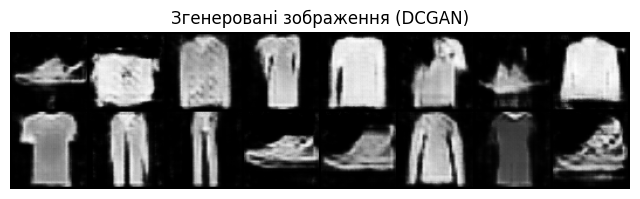

In [ ]:
# Кількість епох (для демонстрації ставимо 5, для результату треба набагато більше)
epochs = 5

for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.shape[0]

        # Тренування дискримінатора
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Тренування генератора
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")

# Візуалізація результату
with torch.no_grad():
    fake_img = gen(torch.randn(16, z_dim, 1, 1).to(device))
    grid = make_grid(fake_img, padding=2, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(grid.cpu().permute(1, 2, 0))
    plt.title("Згенеровані зображення (DCGAN)")
    plt.show()

## Завдання 3: Hugging Face Transformers

In [ ]:
print("--- Translation (En -> Uk) ---")
# Переклад з англійської на українську
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-uk")
text_en = "Artificial intelligence is transforming the world rapidly."
translated = translator(text_en)
print(f"Original: {text_en}")
print(f"Translated: {translated[0]['translation_text']}")

print("\n--- Summarization (Multilingual for UA) ---")
# Сумаризація (використовуємо мультимовну модель mT5)
summarizer = pipeline("summarization", model="csebuetnlp/mT5_multilingual_XLSum")
article_ua = """
Штучний інтелект (ШІ) — це галузь комп'ютерних наук, що займається створенням систем, здатних виконувати завдання, які зазвичай вимагають людського інтелекту.
Ці завдання включають розпізнавання мови, прийняття рішень, візуальне сприйняття та переклад мов.
ШІ стає все більш важливою частиною нашого повсякденного життя, від голосових помічників до автономних автомобілів.
"""
summary = summarizer(article_ua, max_length=50, min_length=10, do_sample=False)
print(f"Summary: {summary[0]['summary_text']}")

print("\n--- Zero-Shot Classification ---")
# класифікація тексту без спеціального навчання
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli") # Мультимовна підтримка через переклад токенів або xlm-roberta
text_to_classify = "Цей новий телефон має жахливу батарею, вона сідає за 2 години."
labels = ["technology", "politics", "sports", "negative feedback"]

result = classifier(text_to_classify, labels)
print(f"Text: {text_to_classify}")
print(f"Labels scores: {list(zip(result['labels'], result['scores']))}")

--- Translation (En -> Uk) ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/305M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/305M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


Original: Artificial intelligence is transforming the world rapidly.
Translated: Штучний інтелект швидко змінює світ.

--- Summarization (Multilingual for UA) ---


config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


Summary: Що означає штучний інтелект?

--- Zero-Shot Classification ---


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


Text: Цей новий телефон має жахливу батарею, вона сідає за 2 години.
Labels scores: [('negative feedback', 0.8667816519737244), ('technology', 0.0728290006518364), ('sports', 0.038745976984500885), ('politics', 0.02164342999458313)]


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/50 [00:00<?, ?it/s]

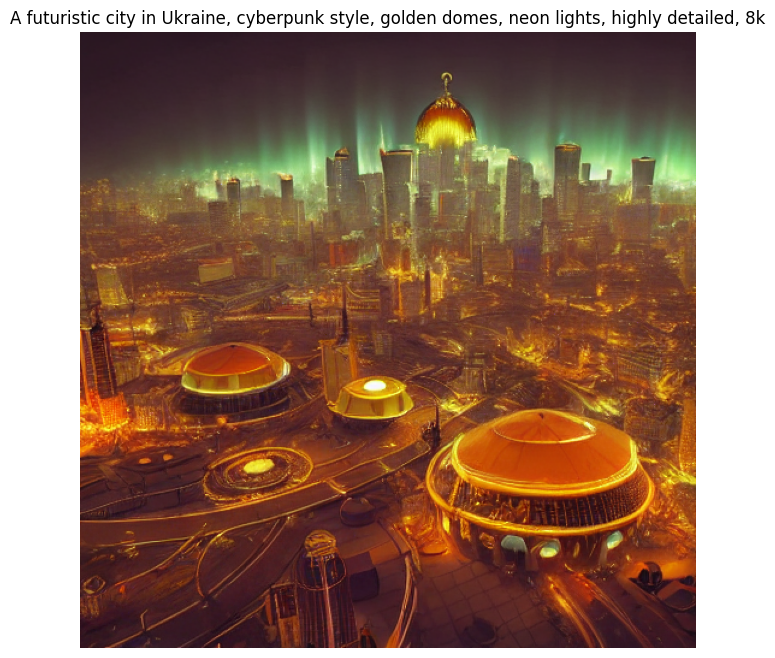

In [ ]:
# Завантаження моделі Stable Diffusion
# використовую float16 для економії пам'яті GPU
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# Генерація зображення за текстовим описом
prompt = "A futuristic city in Ukraine, cyberpunk style, golden domes, neon lights, highly detailed, 8k"
image = pipe(prompt).images[0]

# Відображення
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.title(prompt)
plt.show()